In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


In [97]:
# importing in all the data
wnvd_train = pd.read_csv('../output/train_weather_daily.csv')
wnvd_test = pd.read_csv('../output/test_weather_daily.csv')

In [98]:
# Establishing our baseline accuracy

baseline_accuracy = wnvd_train['WnvPresent'].value_counts()[0]/len(wnvd_train['WnvPresent'])
baseline_accuracy

0.9475537787930707

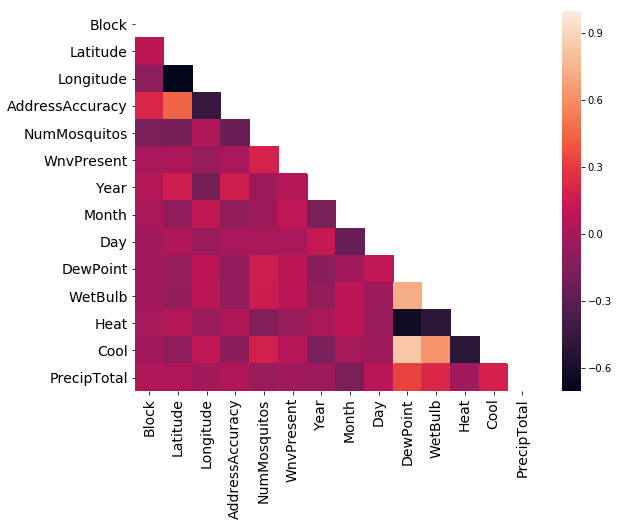

In [99]:
# correlation heatmap

mean_corr = wnvd_train.corr()

fig, ax = plt.subplots(figsize=(9,7))

mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

plt.show()

In [100]:
### Random Forest Classifier with daily weather data

# Converting strings into numerical data
lbl = LabelEncoder()
lbl.fit(list(wnvd_train['Species'].values) + list(wnvd_test['Species'].values))
wnvd_train['Species'] = lbl.transform(wnvd_train['Species'].values)
wnvd_test['Species'] = lbl.transform(wnvd_test['Species'].values)

lbl.fit(list(wnvd_train['Trap'].values) + list(wnvd_test['Trap'].values))
wnvd_train['Trap'] = lbl.transform(wnvd_train['Trap'].values)
wnvd_test['Trap'] = lbl.transform(wnvd_test['Trap'].values)

# Setting X and y for fitting model
y = wnvd_train['WnvPresent']
X = wnvd_train[['Species', 'Trap', 'Heat', 
              'Cool', 'PrecipTotal', 'DewPoint', 'WetBulb']]

# Setting up our test data for predictions
x = wnvd_test[['Species', 'Trap', 'Heat', 
              'Cool', 'PrecipTotal', 'DewPoint', 'WetBulb']]

# Standardizing X
ss = StandardScaler()
X = ss.fit_transform(X)
x = ss.transform(x)
# Splitting Testing and Training 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

rfc_wnvd = RandomForestClassifier(max_depth= None,
                                  n_estimators=10,
                                  )
rfc_wnvd.fit(X_train,y_train)

score_rfc_wnvd = rfc_wnvd.score(X_test,y_test)

# using crossvalidation to check how accurate the model is
cv_wnvd = cross_val_score(rfc_wnvd, X_test, y_test, cv=5, verbose=1).mean()

print('Baseline:', baseline_accuracy)
print('Random Forrest Score:', score_rfc_wnvd)
print('Cross Validation Score:', cv_wnvd)

Baseline: 0.9475537787930707
Random Forrest Score: 0.9349067377236391
Cross Validation Score: 0.9364301097561482


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [101]:
y_preds = rfc_wnvd.predict(X_test)

rfc_df_confusion = pd.crosstab(y_test, y_preds, rownames=['Actual'], colnames=['Predicted'], margins=True)
rfc_df_confusion

Predicted,0,1,All
Actual,,,
0,2443,50,2493
1,121,13,134
All,2564,63,2627


In [107]:
# Predicted Locations of West Nile Virus
wnvd_test['WnvPresent'] = rfc_wnvd.predict(x)
len(wnvd_test[wnvd_test['WnvPresent']==1]['Address'].value_counts())

69

The dataframe above shows the top 20 addresses with the highest presence of WNV. These should be the top priority for the spraying efforts.

In [74]:
# Creating Kaggle submission file 

submission = pd.DataFrame(rfc_wnvd.predict_proba(x), columns=['filler','WnvPresent'])['WnvPresent']
submission.index += 1
submission.index.rename('Id', inplace = True)
submission.to_csv('../output/submission2.csv')